# Chapter 07 — Cellbender UMAP Clustering and Doublet analysis

## Objective

In this chapter, we load all single-nucleus RNA-seq datasets required for benchmarking the **Singulator + FACS** and **Singulator + LeviCell** protocols. We also verify metadata consistency, perform basic integrity checks, and prepare the data objects for downstream analysis.

This includes:

- Locating the data on the shared filesystem (Iris)
- Loading raw count matrices (e.g., `filtered_feature_bc_matrix.h5` from 10X)
- Loading data into `AnnData` objects

## Data Source

The data for this benchmarking project is stored on the **Iris** HPC filesystem under:

`/data1/collab002/sail/isabl/datalake/prod/010/collaborators/SAIL/projects/singulator_debris_removal_and/experiments`

We will be working with the data under identifier `MB-4027_*`


## Core Imports

In [1]:
import os
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, Dict, List, Union

## File Paths and Metadata

In [2]:
# Constants
DATA_DIR = "./data"
READ_ONLY_DIR = os.path.join(DATA_DIR, "read_only")
FIGURES_OUTPUT_DIR = os.path.join(DATA_DIR, "figures", "chapter_06_cellbender_basic_analysis")
RAW_FEATURE_BC_MATRIX_FILE_NAME = "raw_feature_bc_matrix.h5"

GENE_SETS_DIR = os.path.join(DATA_DIR, "gene_sets_and_info")

# Make sure figures output directory exists
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)

ANALYSIS_DIR = os.path.join(DATA_DIR, "analysis")
INPUT_ADATA_DIR = os.path.join(
    ANALYSIS_DIR, "adatas", "chapter_06_cellbender_basic_analysis"
)
OUTPUT_ADATA_DIR = os.path.join(ANALYSIS_DIR, "adatas", "chapter_07_cellbender_UMAP_clustering")

# Make sure output adata dir directory exists
os.makedirs(OUTPUT_ADATA_DIR, exist_ok=True)

# Sample metadata - in data/metadata.tsv
samples = {
    "SF_N": ("MB-4027_SF_N", "Normal Colon", "Singulator+FACS"),
    "SL_N": ("MB-4027_SL_N", "Normal Colon", "Singulator+LeviCell"),
    "SF_T": ("MB-4027_SF_T", "Tumor Colon", "Singulator+FACS"),
    "SL_T": ("MB-4027_SL_T", "Tumor Colon", "Singulator+LeviCell"),
    "SF_LN": ("MB-4027_SF_LN", "Normal Liver", "Singulator+FACS"),
    "SL_LN": ("MB-4027_SL_LN", "Normal Liver", "Singulator+LeviCell"),
}

# Color palette for plotting
protocol_color_palette = {
    "Singulator+FACS": "#AEC6CF",
    "Singulator+LeviCell": "#FFDAB9",
}

## Read in AnnDatas

In [4]:
# Load AnnData objects
adatas = {}
adata_metadata = {}
adata_tissues = []

for key, (folder, tissue, protocol) in samples.items():
    file_path = os.path.join(INPUT_ADATA_DIR, f"{key}_adata.h5ad")
    adata = sc.read_h5ad(file_path)
    adatas[key] = adata
    adata_metadata[key] = (tissue, protocol)
    adata_tissues.append(tissue)
    print(f"{key}: {adata}")

SF_N: AnnData object with n_obs × n_vars = 4483 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mitochondrial', 'ribosomal', 'apoptosis', 'housekeeping'
SL_N: AnnData object with n_obs × n_vars = 5505 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping'
    var: 'gene_ids', '

### Run QC Metrics

### Doublet Analysis

In [5]:
def run_scrublet(adata: sc.AnnData) -> None:
    """
    Run Scrublet doublet detection on the given AnnData object.

    Parameters:
    adata (sc.AnnData): The AnnData object to analyze.
    """
    sc.pp.scrublet(
        adata,
        sim_doublet_ratio=2.0,
        expected_doublet_rate=0.06,
        knn_dist_metric="euclidean",
        log_transform=True,
        n_prin_comps=30,
        random_state=0,
    )  # From Roshan's workshop


for key, adata in adatas.items():
    print(f"Running Scrublet on {key}...")
    run_scrublet(adata)

Running Scrublet on SF_N...


adata.X seems to be already log-transformed.


Running Scrublet on SL_N...


adata.X seems to be already log-transformed.


Running Scrublet on SF_T...


adata.X seems to be already log-transformed.


Running Scrublet on SL_T...


adata.X seems to be already log-transformed.


Running Scrublet on SF_LN...


adata.X seems to be already log-transformed.


Running Scrublet on SL_LN...


adata.X seems to be already log-transformed.


## Preprocessing and Graph Computation

In [6]:
# Use downsampled reads for analysis
for key, adata in adatas.items():
    adata.layers["raw_data"] = adata.X.copy()
    sc.pp.filter_cells(adata, min_counts=500)  # Ensure no cells with zero counts
    sc.pp.normalize_total(
        adata, target_sum=None, inplace=True
    )  # From both Roshan and sc-best-practices
    sc.pp.log1p(adata)

# Combine adatas by tissue
combined_by_tissue = {}
for tissue in adata_tissues:
    tissue_adatas = []
    for key, (tissue_name, protocol) in adata_metadata.items():
        if tissue_name == tissue:
            adata = adatas[key].copy()
            adata.obs["protocol"] = protocol
            adata.obs["tissue"] = tissue
            adata.obs["sample"] = key
            adata.obs_names_make_unique()
            adata.var_names_make_unique()
            tissue_adatas.append(adata)

    combined = sc.concat(
        tissue_adatas,
        label="sample",
        keys=[a.obs["sample"].iloc[0] for a in tissue_adatas],
    )

    # Make obs and var names unique
    combined.obs_names_make_unique()
    combined.var_names_make_unique()

    # Filter cells and genes
    sc.pp.filter_cells(
        combined, min_genes=20
    )  # From (https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html)
    sc.pp.filter_genes(combined, min_cells=np.exp(4))  # From Roshan's workshop

    # Compute graphs
    sc.pp.highly_variable_genes(
        combined,
        flavor="seurat_v3",
        n_top_genes=4000,
        batch_key="protocol",
        layer="raw_data",
    )  # Using batch_key to account for protocol differences - want to keep genes that are variable across both protocols
    sc.pp.pca(
        combined, n_comps=None, use_highly_variable=True, random_state=0
    )  #  Roshan's workshop calculated 100 comps, then moved forward with 30, but this took long - if set to None, "Defaults to 50, or (1 - minimum dimension size of selected representation)"
    sc.pp.neighbors(
        combined, n_neighbors=30, use_rep="X_pca", metric="euclidean", random_state=0
    )  # From Roshan's workshop

    # Compute UMAP and clustering
    sc.tl.umap(combined, min_dist=0.1, random_state=0)  # From Roshan's workshop
    sc.tl.leiden(combined, resolution=1, random_state=0)  # From Roshan's workshop

    combined_by_tissue[tissue] = combined

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(adata, mask_var, use_highly_variable)
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

### Plotting Functions

In [7]:
def plot_umap_by_obs_feature(
    combined_by_tissue: Dict[str, sc.AnnData],
    feature: str,
    color_palette: Union[Dict[str, str], str] = "viridis",
    title: str = None,
    size: float = 8.0,
    alpha: float = 0.8,
    log_scale: bool = False,
    clip_values: tuple = None,
    shuffle: bool = True,
) -> plt.Figure:
    """
    Plot UMAPs for each tissue colored by a feature in .obs.

    Args:
        combined_by_tissue: Dictionary of AnnData objects per tissue.
        feature: Column in .obs to plot (categorical or continuous).
        color_palette: Dict for categorical or colormap name for continuous.
        title: Figure title.
        size: Dot size.
        alpha: Dot transparency.
        log_scale: Use log1p scale (applies to continuous features).
        clip_values: (low, high) quantiles to clip (e.g., (0.01, 0.99)).
        shuffle: Shuffle points before plotting (default True).

    Returns:
        Matplotlib figure.
    """
    sns.set_theme(style="white")
    tissues = list(combined_by_tissue.keys())
    fig, axes = plt.subplots(
        1, len(tissues), figsize=(6 * len(tissues), 5), squeeze=False
    )

    # Determine global vmin/vmax
    all_values = pd.concat(
        [adata.obs[feature] for adata in combined_by_tissue.values()]
    )
    clip_low = (
        max(1, all_values.quantile(clip_values[0]))
        if clip_values and log_scale
        else all_values.min()
    )
    clip_high = all_values.quantile(clip_values[1]) if clip_values else all_values.max()
    vmin, vmax = (
        (np.log1p(clip_low), np.log1p(clip_high))
        if log_scale
        else (clip_low, clip_high)
    )

    # Convert string colormap to dict for categorical legend if needed
    def make_categorical_palette(vals, cmap_name):
        cmap = mpl.colormaps.get_cmap(cmap_name).resampled(len(vals))
        return {val: mpl.colors.to_hex(cmap(i)) for i, val in enumerate(sorted(vals))}

    for i, tissue in enumerate(tissues):
        ax = axes[0, i]
        adata = combined_by_tissue[tissue]
        coords = adata.obsm["X_umap"]
        values = adata.obs[feature].copy()
        # Sort to plot False/0 first, True/1 last (on top)
        if pd.api.types.is_bool_dtype(values) or set(values.unique()) <= {0, 1}:
            values = values.astype(bool)
            sorted_idx = np.argsort(values.values)  # False first, True last
            coords = coords[sorted_idx]
            values = values.iloc[sorted_idx]
        elif shuffle:
            np.random.seed(0)
            shuffled = np.random.permutation(adata.n_obs)
            coords = coords[shuffled]
            values = values.iloc[shuffled]

        if (
            values.dtype.name == "category"
            or values.dtype == object
            or isinstance(color_palette, dict)
        ):
            # Categorical
            if isinstance(color_palette, str):
                unique_vals = sorted(values.dropna().unique())
                color_palette = make_categorical_palette(unique_vals, color_palette)
            sns.scatterplot(
                x=coords[:, 0],
                y=coords[:, 1],
                hue=values,
                palette=color_palette,
                ax=ax,
                s=size,
                alpha=alpha,
                linewidth=0,
            )
            ax.legend_.remove()
        else:
            # Continuous
            values = values.clip(clip_low, clip_high)
            if log_scale:
                values = np.log1p(values)
            scatter = ax.scatter(
                coords[:, 0],
                coords[:, 1],
                c=values,
                cmap=color_palette,
                vmin=vmin,
                vmax=vmax,
                s=size,
                alpha=alpha,
                linewidths=0,
            )
            if i == len(tissues) - 1:
                cb = plt.colorbar(scatter, ax=ax, fraction=0.046, pad=0.04)
                if log_scale:
                    raw_ticks = np.logspace(
                        np.log10(max(1, clip_low)), np.log10(clip_high), num=6
                    )
                    cb.set_ticks(np.log1p(raw_ticks))
                    cb.set_ticklabels(
                        [
                            f"{int(t/1000)}k" if t >= 1000 else str(int(t))
                            for t in raw_ticks
                        ]
                    )
                else:
                    raw_ticks = np.linspace(clip_low, clip_high, 6)
                    cb.set_ticks(raw_ticks)
                    cb.set_ticklabels([f"{int(t):,}" for t in raw_ticks])
                cb.ax.set_ylabel(
                    feature.replace("log1p_", "").replace("_", " ").title(),
                    rotation=270,
                    labelpad=15,
                )

        ax.set_title(tissue, weight="bold")
        ax.set_xlabel("UMAP1")
        ax.set_ylabel("UMAP2" if i == 0 else "")
        ax.set_xticks([])
        ax.set_yticks([])

    # Add global legend for categorical data
    if (
        values.dtype.name == "category"
        or values.dtype == object
        or pd.api.types.is_bool_dtype(values)
    ):
        unique_vals = sorted(
            values.dropna().unique(),
            key=lambda x: float(x) if str(x).replace(".", "", 1).isdigit() else str(x),
        )
        legend_elements = [
            mpl.patches.Patch(facecolor=color_palette.get(val, "gray"), label=val)
            for val in unique_vals
        ]
        fig.legend(
            handles=legend_elements,
            title=feature,
            loc="upper right",
            bbox_to_anchor=(1.05, 1.05),
            fontsize="small",
            title_fontsize="medium",
        )

    if not title:
        title = f"UMAP Colored by {feature.replace('_', ' ').title()}"
        if log_scale:
            title += " (Log Scale)"
        if clip_values:
            title += f" (Clipped {clip_values[0]*100:.1f}%-{clip_values[1]*100:.1f}%)"

    plt.suptitle(title, fontsize=16, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    return fig

### Plot by Protocol

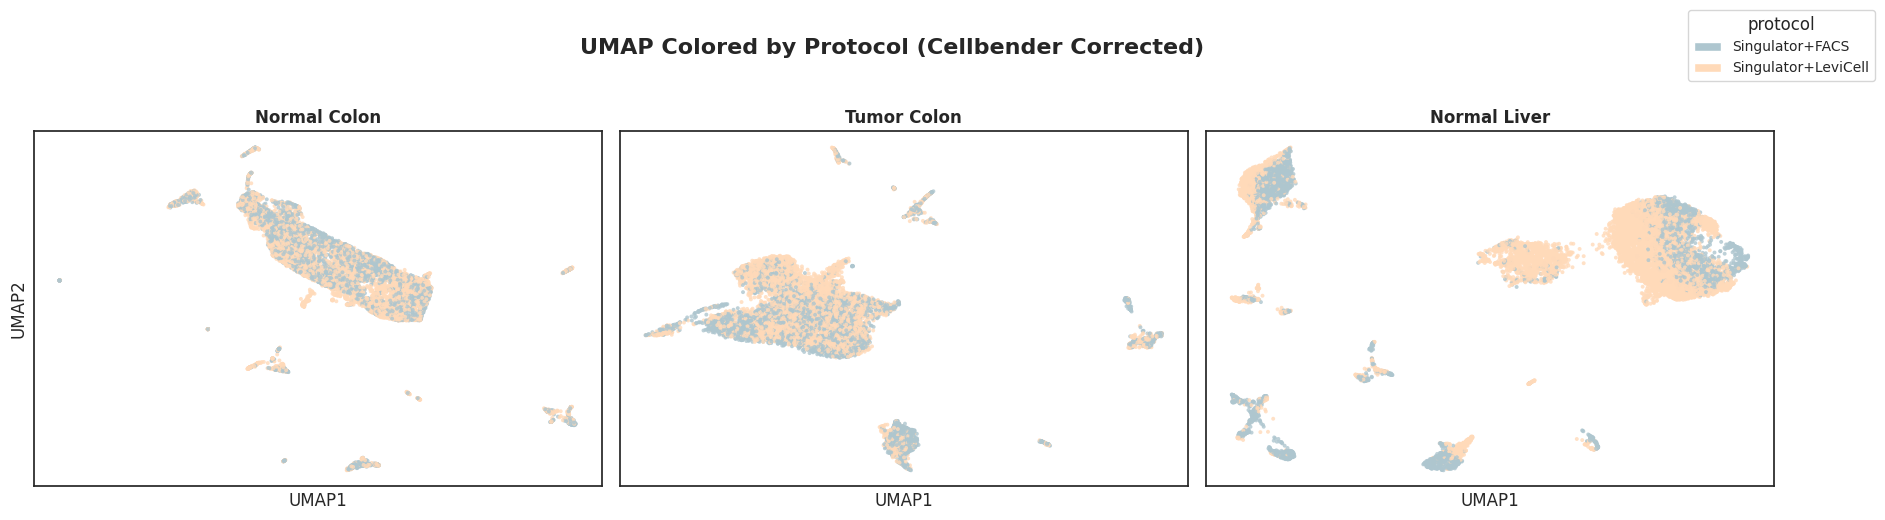

In [8]:
# Plot UMAP colored by protocol
fig = plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="protocol",
    color_palette=protocol_color_palette,
    title="UMAP Colored by Protocol (Cellbender Corrected)",
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "umap_by_protocol.png"), bbox_inches="tight"
)

### Plot by Library Size

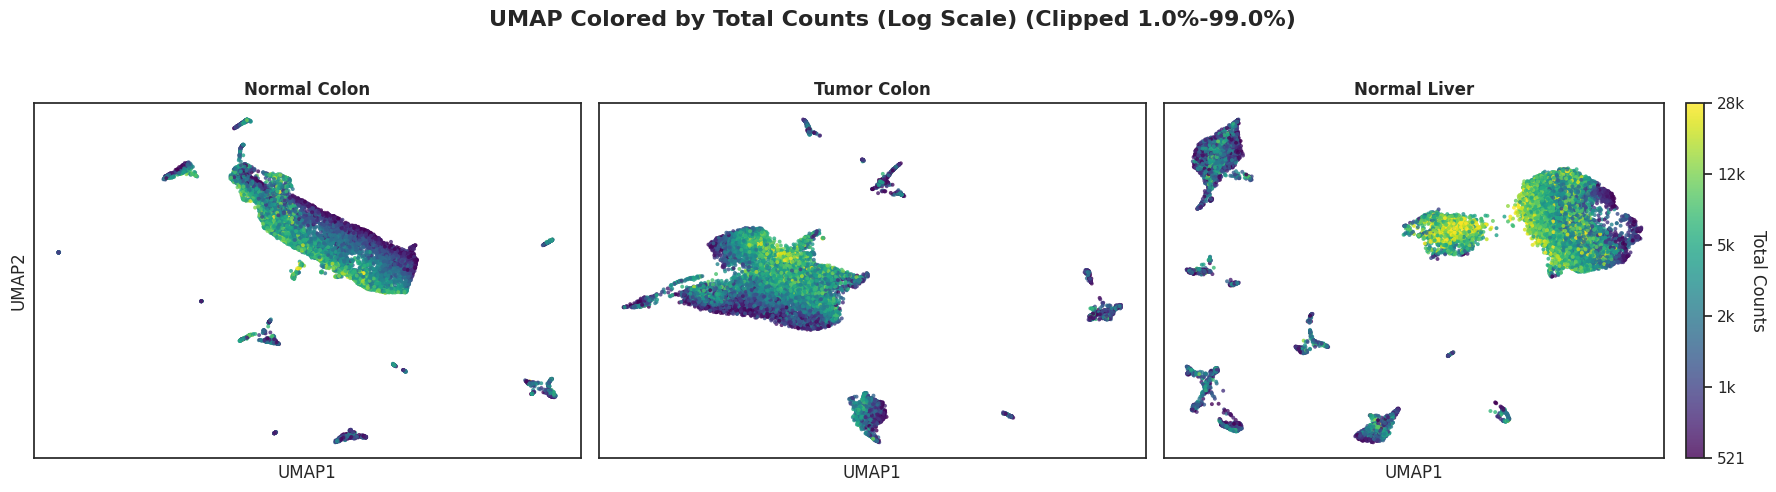

In [9]:
# Plot UMAP colored by library szie
plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="total_counts",
    color_palette="viridis",
    log_scale=True,
    clip_values=(0.01, 0.99),
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "umap_by_library_size.png"), bbox_inches="tight"
)

### Plot by Leiden Cluster

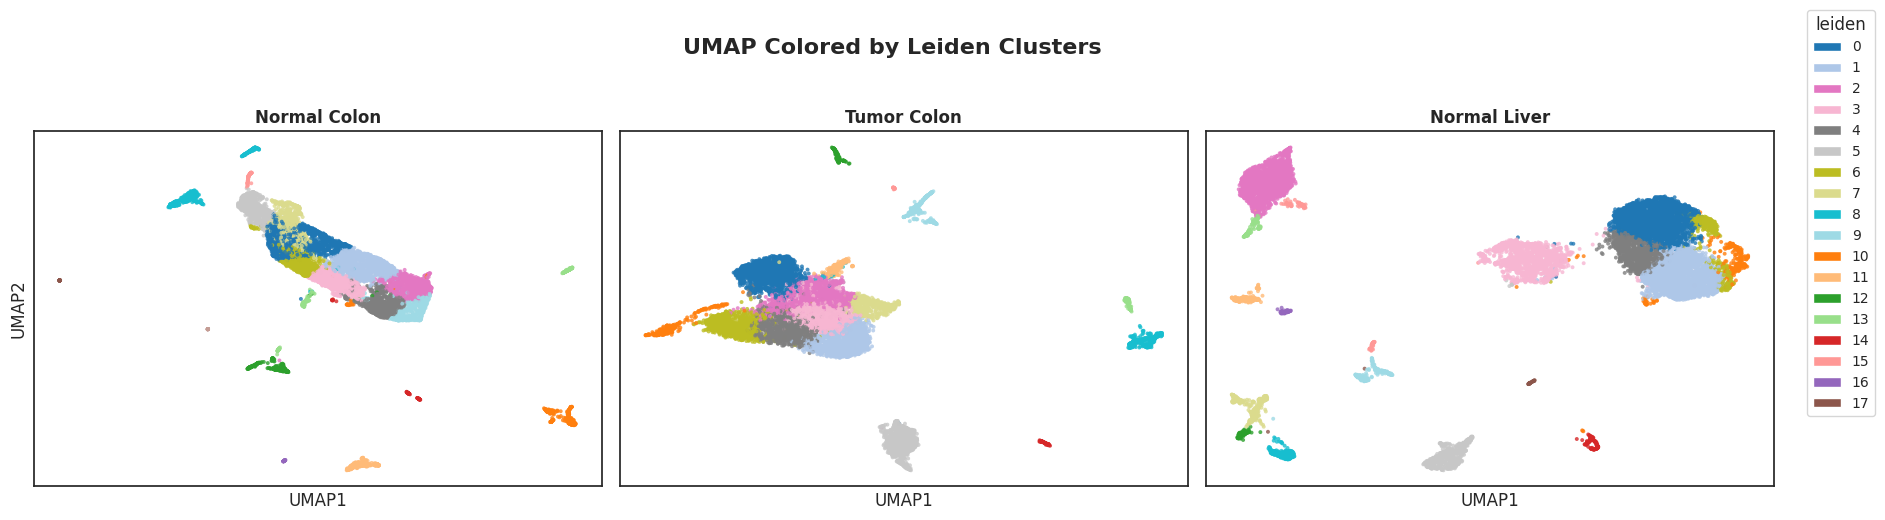

In [ ]:
# Plot UMAP colored by leiden cluster
plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="leiden",
    color_palette="tab20",
    title="UMAP Colored by Leiden Clusters",
)

# Save the figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "umap_by_leiden.png"), bbox_inches="tight")

### Plot Doublets

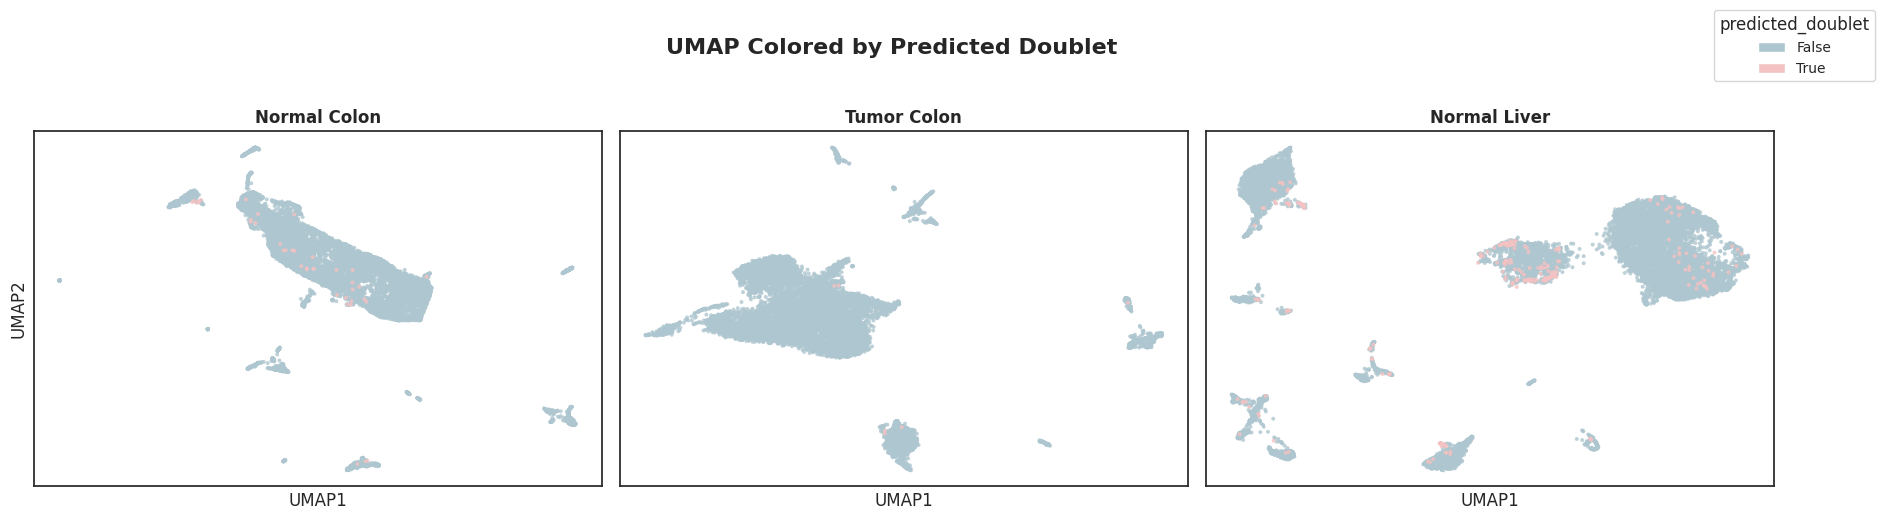

In [11]:
doublet_palette = {
    False: "#aec6cf",  # pastel blue
    True: "#f4c2c2",  # pastel pink
}

plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="predicted_doublet",
    color_palette=doublet_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "umap_by_predicted_doublets.png"),
    bbox_inches="tight",
)

### Plot by Mitochondrial Gene Percentage

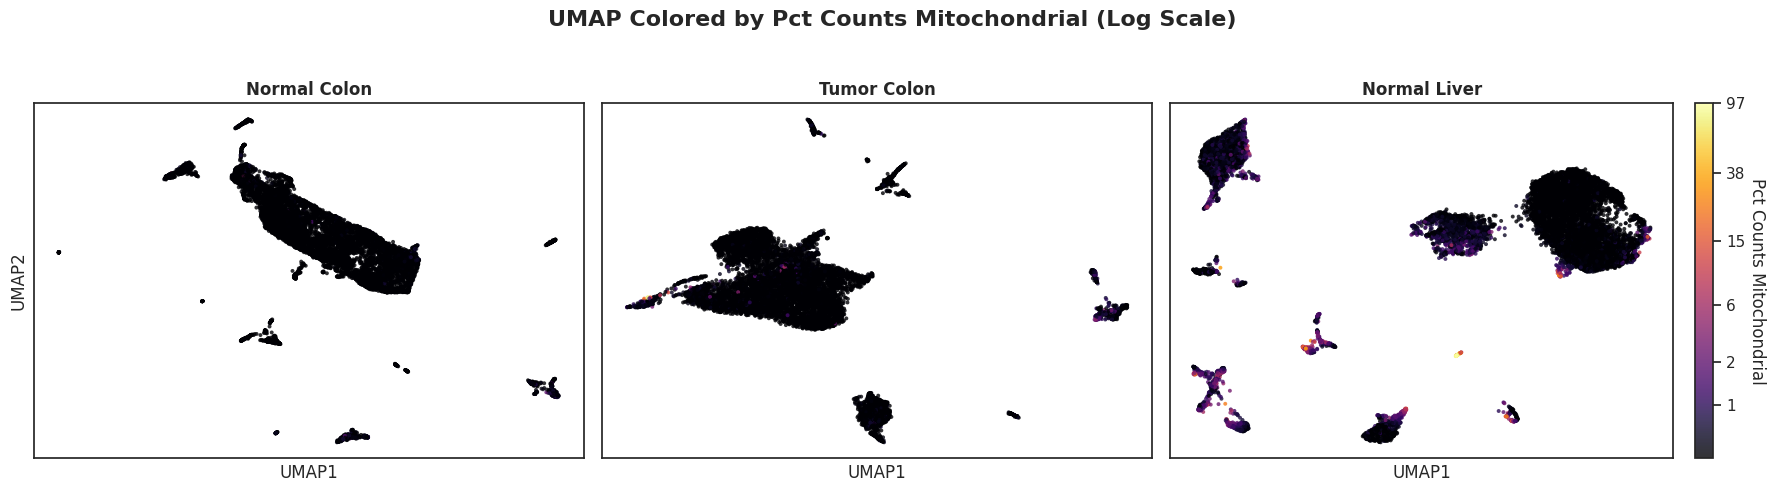

In [12]:
# Plot UMAP colored by total counts of apoptosis genes
plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="pct_counts_mitochondrial",
    color_palette="inferno",
    log_scale=True,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "umap_by_pct_counts_mitochondrial.png"),
    bbox_inches="tight",
)

### Plot by Ribosomal Gene Percentage

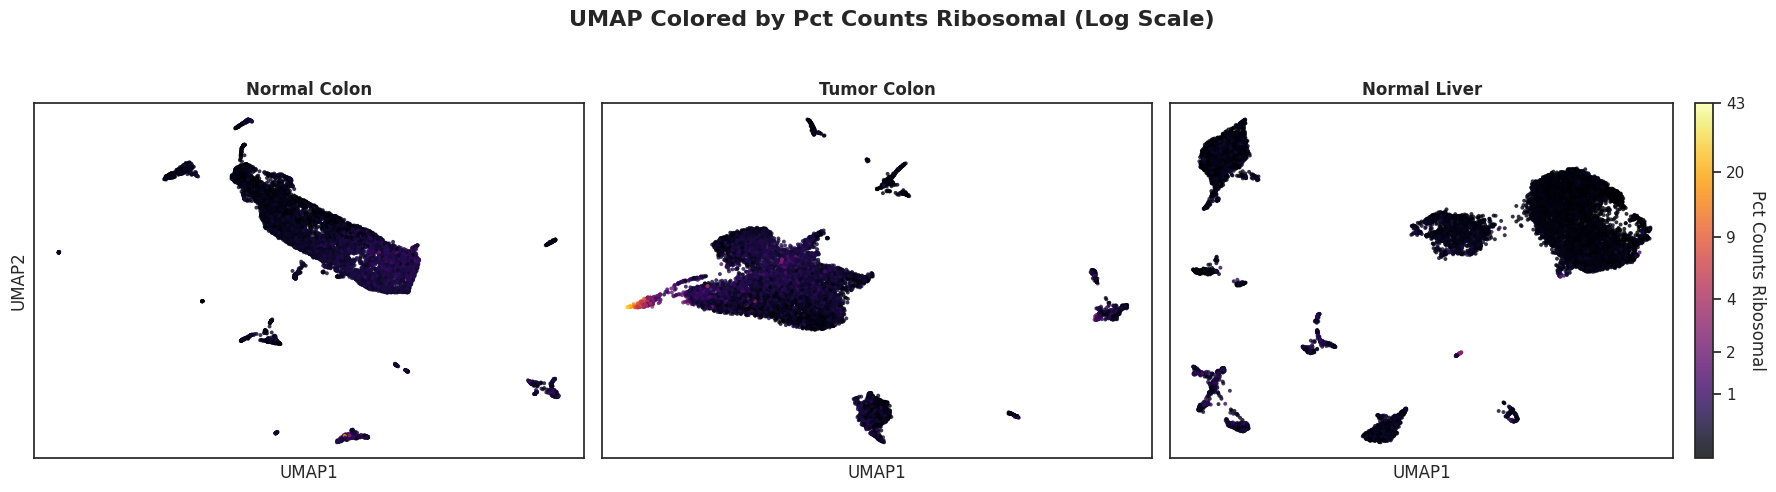

In [13]:
# Plot UMAP colored by total counts of apoptosis genes
plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="pct_counts_ribosomal",
    color_palette="inferno",
    log_scale=True,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "umap_by_pct_counts_ribosomal.png"),
    bbox_inches="tight",
)

### Plot by Apoptosis Gene Percentage

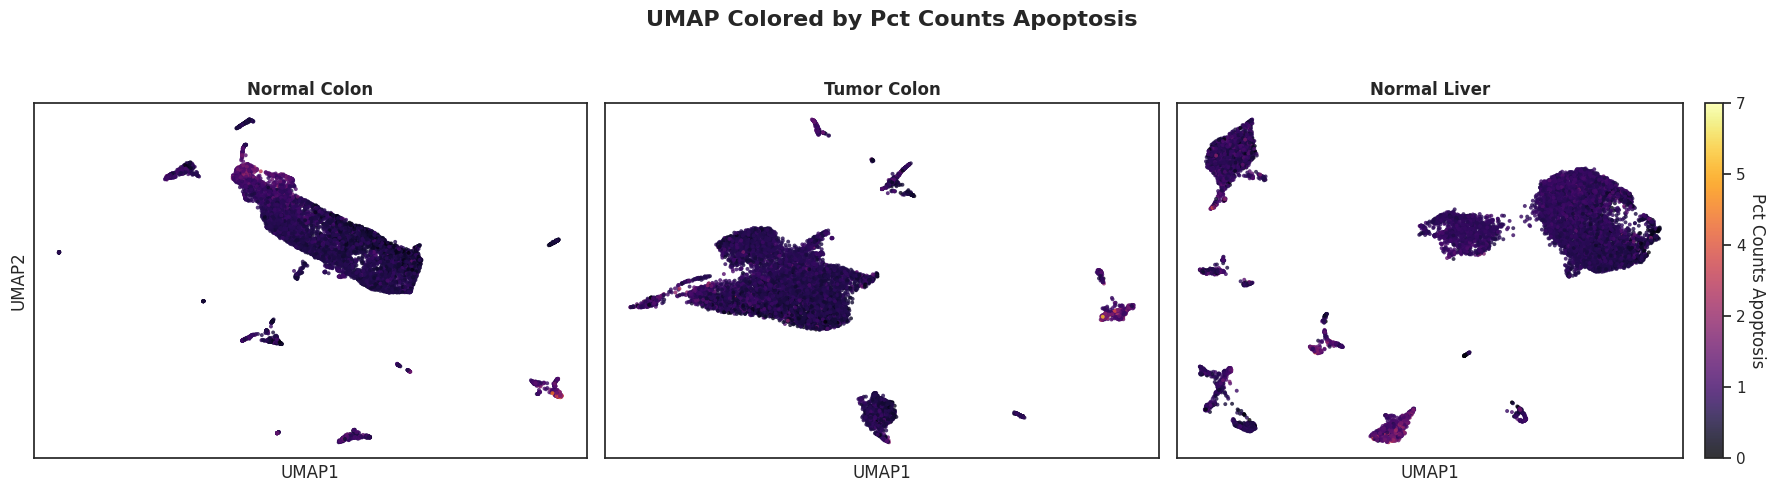

In [14]:
# Plot UMAP colored by total counts of apoptosis genes
plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="pct_counts_apoptosis",
    color_palette="inferno",
    log_scale=False,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "umap_by_pct_counts_apopotosis.png"),
    bbox_inches="tight",
)

### Plot by Housekeeping Gene Percentage

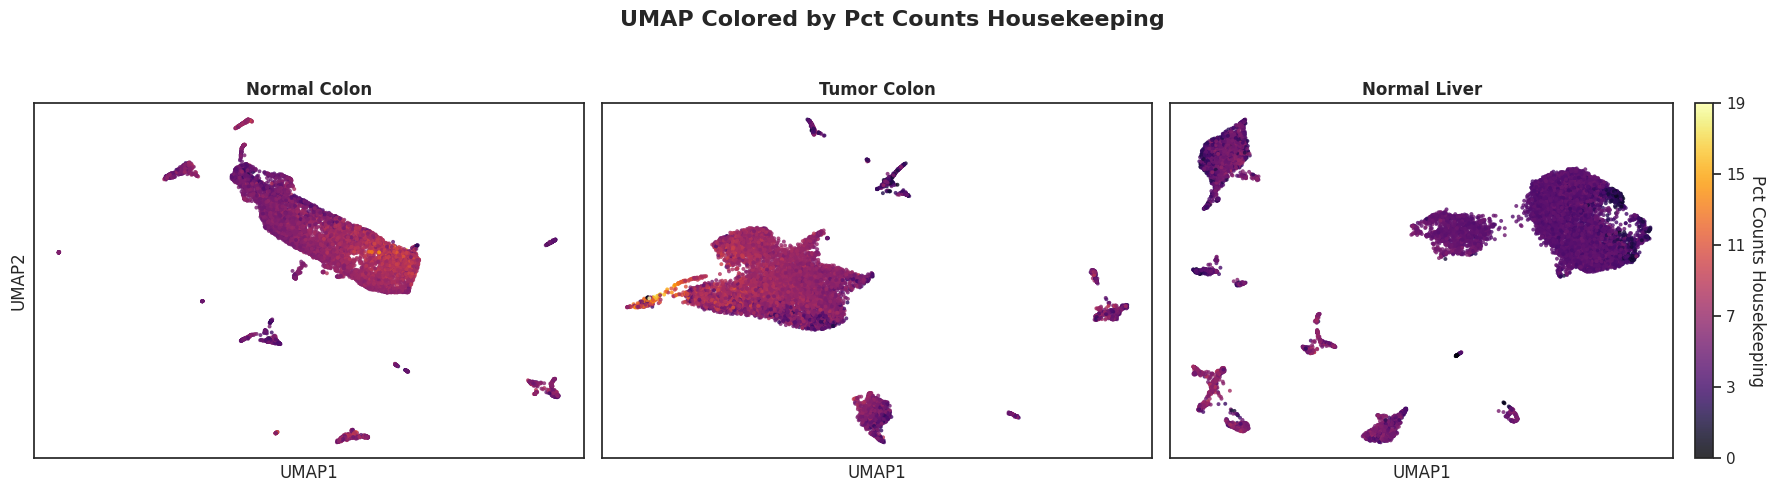

In [15]:
# Plot UMAP colored by total counts of apoptosis genes
plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="pct_counts_housekeeping",
    color_palette="inferno",
    log_scale=False,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "umap_by_pct_counts_housekeeping.png"),
    bbox_inches="tight",
)

## Plot Barplots/Further Analysis

### Plotting Functions

In [16]:
def plot_cluster_protocol_stackplots(
    combined_by_tissue: Dict[str, sc.AnnData],
    cluster_key: str = "leiden",
    protocol_key: str = "protocol",
    protocol_palette: Dict[str, str] = None,
) -> plt.Figure:
    """
    For each tissue, plot a stacked barplot showing how many cells from each protocol
    make up each cluster (cluster_key).

    Args:
        combined_by_tissue (dict): Dict of AnnData objects per tissue name.
        cluster_key (str): Column in .obs for clustering (e.g. 'leiden').
        protocol_key (str): Column in .obs for protocol (e.g. 'protocol').
        protocol_palette (dict): Mapping of protocol to color.

    Returns:
        fig (matplotlib.Figure): The figure containing the stacked barplots.
    """
    sns.set_theme(style="white", font_scale=1.1)
    # Build long-form dataframe with one row per (Tissue, Cluster, Protocol)
    records = []
    for tissue, adata in combined_by_tissue.items():
        df = adata.obs[[cluster_key, protocol_key]].copy()
        df["Tissue"] = tissue
        records.append(df)

    df_all = pd.concat(records)
    df_all[cluster_key] = df_all[cluster_key].astype(int)

    # Count cells per group
    counts = (
        df_all.groupby(["Tissue", cluster_key, protocol_key], observed=True)
        .size()
        .reset_index(name="Count")
    )

    # Pivot to wide form then normalize row-wise
    pivoted = counts.pivot_table(
        index=["Tissue", cluster_key],
        columns=protocol_key,
        values="Count",
        fill_value=0,
    )
    pivoted_norm = pivoted.div(pivoted.sum(axis=1), axis=0).reset_index()

    unique_tissues = pivoted_norm["Tissue"].unique()

    fig, axes = plt.subplots(
        1, len(unique_tissues), figsize=(6 * len(unique_tissues), 5), sharey=True
    )

    if len(unique_tissues) == 1:
        axes = [axes]

    for i, tissue in enumerate(unique_tissues):
        ax = axes[i]
        df_tissue = pivoted_norm[pivoted_norm["Tissue"] == tissue]
        clusters = df_tissue[cluster_key]

        bottom = pd.Series([0.0] * len(clusters), index=clusters)
        for protocol in protocol_palette.keys():
            if protocol in df_tissue.columns:
                values = df_tissue[protocol].values
                ax.bar(
                    clusters,
                    values,
                    bottom=bottom.loc[clusters].values,
                    color=protocol_palette[protocol],
                    label=protocol,
                )
                bottom.loc[clusters] += values

        ax.set_title(tissue, fontsize=13, weight="bold")
        ax.set_xlabel("Cluster")
        ax.set_ylabel("Proportion of Cells" if i == 0 else "")
        ax.set_xticks(range(len(clusters)))
        ax.set_xticklabels(clusters, rotation=45)
        ax.set_ylim(0, 1)

    fig.legend(
        handles=[
            mpl.patches.Patch(color=c, label=p) for p, c in protocol_palette.items()
        ],
        title="Protocol",
        loc="upper right",
        bbox_to_anchor=(1.05, 1),
    )
    plt.suptitle(
        "Cluster Composition by Protocol Across Tissues", fontsize=16, weight="bold"
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    return fig

In [17]:
# Function to plot a scalar metric from multiple AnnData objects and create a subplot for each unique tissue.


def adaptive_formatter(x, _):
    """
    Formats large numeric values for axis tick labels using adaptive human-readable notation.

    - Values ≥ 1,000,000 are shown with 'M' (e.g., 2,500,000 → '2.5M')
    - Values < 1,000,000 are shown as plain integers (e.g., 42,000 → '42000')
    """
    if x >= 1e6:
        return f"{x / 1e6:.1f}M"
    else:
        return f"{int(x)}"


def plot_adata_scalar_metric(
    adatas: dict,
    adata_metadata: dict,
    metric_func: Callable,
    metric_label: str,
    protocol_color_palette: dict,
    title:str = None,
) -> None:
    """
    Plots a scalar metric computed on each AnnData object, grouped by tissue and protocol. Will create as many subplots as there are unique tissues.
    The metric function should return a scalar value for each AnnData object.
    The metric label is used for the Y-axis and title, and the color palette maps protocol names to colors.
    The function uses adaptive formatting for the Y-axis to handle large numbers (e.g., millions and thousands).
    It also annotates the bars with the actual values for clarity.

    Args:
        adatas: dict of AnnData objects keyed by sample ID
        adata_metadata: dict of (tissue, protocol) tuples keyed by sample ID
        metric_func: function that takes an AnnData object and returns a scalar
        metric_label: label to show on the Y-axis and title (e.g., "Total Reads")
        protocol_color_palette: mapping of protocol name to color
    Returns:
        fig: matplotlib figure object containing the plot
    """
    # Assemble data
    rows = []
    for key, adata in adatas.items():
        tissue, protocol = adata_metadata[key]
        value = metric_func(adata)
        rows.append({"Tissue": tissue, "Protocol": protocol, "Value": value})
    df = pd.DataFrame(rows)

    # Determine unique tissues (to define subplots)
    unique_tissues = df["Tissue"].unique()

    # Plot setup
    sns.set_theme(style="white", font_scale=1.1)
    fig, axes = plt.subplots(
        1, len(unique_tissues), figsize=(5 * len(unique_tissues), 5), sharey=True
    )

    if len(unique_tissues) == 1:
        axes = [axes]  # Ensure axes is always iterable

    for i, tissue in enumerate(unique_tissues):
        ax = axes[i]
        sns.barplot(
            data=df[df["Tissue"] == tissue],
            x="Protocol",
            y="Value",
            hue="Protocol",
            palette=protocol_color_palette,
            legend=False,
            ax=ax,
        )
        ax.set_title(tissue, fontsize=13, weight="bold")
        ax.set_xlabel("")
        ax.set_ylabel(metric_label if i == 0 else "")
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(adaptive_formatter))

        for p in ax.patches:
            val = p.get_height()
            ax.annotate(
                f"{int(val):,}",
                (p.get_x() + p.get_width() / 2.0, val),
                ha="center",
                va="bottom",
                fontsize=10,
                weight="bold",
            )
    if not title:
        title = f"{metric_label} by Protocol Across Tissues"
    plt.suptitle(
        title, fontsize=16, weight="bold"
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    legend_elements = [
        mpl.patches.Patch(facecolor=color, label=label)
        for label, color in protocol_color_palette.items()
    ]
    fig.legend(
        handles=legend_elements,
        title="Protocol",
        loc="upper right",
        bbox_to_anchor=(1.05, 1.05),
    )
    return fig

In [18]:
# Function to plot a metric distribution from multiple AnnData objects and create a subplot for each unique tissue.


def plot_adata_metric_histogram(
    adatas: Dict[str, sc.AnnData],
    adata_metadata: Dict[str, tuple],
    field: str,
    axis: str = "obs",
    bins: int = 100,
    x_label: str = None,
    log_x: bool = True,
    log_y: bool = False,
    title: str = "Distribution by Protocol Across Tissues",
    row_label: str = "Cell",
    protocol_color_palette: Dict[str, str] = None,
    proportion: bool = False,
) -> None:
    """
    Plots the distribution of a field (column) from each AnnData object, grouped by tissue and protocol.
    """
    # Gather data
    rows = []
    for key, adata in adatas.items():
        tissue, protocol = adata_metadata[key]
        values = getattr(adata, axis)[field]
        if log_x:
            values = np.log1p(values)
        for val in values:
            rows.append({"Tissue": tissue, "Protocol": protocol, "Value": val})
    df = pd.DataFrame(rows)

    # Unique tissues
    unique_tissues = df["Tissue"].unique()

    # Plot
    sns.set_theme(style="white", font_scale=1.1)
    fig, axes = plt.subplots(
        1, len(unique_tissues), figsize=(5 * len(unique_tissues), 5), sharey=True
    )
    if len(unique_tissues) == 1:
        axes = [axes]

    stat_type = "probability" if proportion else "count"

    for i, tissue in enumerate(unique_tissues):
        ax = axes[i]
        sns.histplot(
            data=df[df["Tissue"] == tissue],
            x="Value",
            hue="Protocol",
            palette=protocol_color_palette,
            bins=bins,
            element="step",
            stat=stat_type,
            common_norm=False,
            legend=False,
            ax=ax,
        )
        if log_y:
            ax.set_yscale("log")

        ax.set_title(tissue, fontsize=13, weight="bold")
        ax.set_xlabel(x_label or (f"log1p({field})" if log_x else field))
        if i == 0:
            ax.set_ylabel(f"{row_label} {'Proportion' if proportion else 'Count'}")
        else:
            ax.set_ylabel("")

    # Axis scaling
    if log_x:
        raw_values = np.concatenate(
            [getattr(adatas[key], axis)[field].to_numpy() for key in adatas]
        )
        raw_values = raw_values[raw_values > 0]
        vmin, vmax = raw_values.min(), raw_values.max()
        min_exp, max_exp = int(np.floor(np.log10(vmin))), int(np.ceil(np.log10(vmax)))
        xticks_raw = [10**e for e in range(min_exp, max_exp + 1)]
        xticks_log = np.log1p(xticks_raw)

        for ax in axes:
            ax.set_xlim(np.log1p(vmin), np.log1p(vmax))
            ax.set_xticks(xticks_log)
            ax.set_xticklabels([f"{x:,}" for x in xticks_raw])
    else:
        all_values = np.concatenate(
            [getattr(adatas[key], axis)[field].to_numpy() for key in adatas]
        )
        vmin, vmax = all_values.min(), all_values.max()
        for ax in axes:
            ax.set_xlim(vmin, vmax)

    # Finalize
    plt.suptitle(title, fontsize=16, weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    legend_elements = [
        mpl.patches.Patch(facecolor=color, label=label)
        for label, color in protocol_color_palette.items()
    ]
    fig.legend(
        handles=legend_elements,
        title="Protocol",
        loc="upper right",
        bbox_to_anchor=(1.05, 1.05),
    )
    return fig

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict


def plot_doublet_stack_by_cluster(
    combined_by_tissue: Dict[str, "sc.AnnData"],
    tissue: str,
    color_palette: Dict[str, str],
) -> None:
    """
    Plot stacked barplot of doublet vs non-doublet counts per cluster, grouped by protocol.

    Args:
        combined_by_tissue: Dict of tissue name to AnnData.
        tissue: Tissue name to plot.
        color_palette: Dict of protocol -> hex color (opaque), e.g. {"Singulator+FACS": "#6B9EB2"}
    """
    adata = combined_by_tissue[tissue].copy()
    adata.obs["leiden"] = adata.obs["leiden"].astype(str)

    # Total cells per cluster/protocol
    cell_counts = (
        adata.obs.groupby(["leiden", "protocol"]).size().reset_index(name="total_cells")
    )

    # Doublet counts
    doublet_counts = (
        adata.obs.groupby(["leiden", "protocol"])["predicted_doublet"]
        .sum()
        .reset_index()
        .rename(columns={"predicted_doublet": "doublet_count"})
    )

    # Merge and compute non-doublets
    summary = pd.merge(doublet_counts, cell_counts, on=["leiden", "protocol"])
    summary["non_doublets"] = summary["total_cells"] - summary["doublet_count"]
    summary["leiden"] = summary["leiden"].astype(int)
    summary = summary.sort_values("leiden")

    # Plot setup
    fig = plt.figure(figsize=(9, 6))
    bar_width = 0.35
    leiden_clusters = summary["leiden"].unique()
    x = np.arange(len(leiden_clusters))
    protocols = summary["protocol"].unique()
    offsets = {protocol: (i - 0.5) * bar_width for i, protocol in enumerate(protocols)}
    faded_colors = {protocol: color_palette[protocol] + "80" for protocol in protocols}

    for protocol in protocols:
        subset = summary[summary["protocol"] == protocol]
        indices = [np.where(leiden_clusters == cl)[0][0] for cl in subset["leiden"]]

        plt.bar(
            x[indices] + offsets[protocol],
            subset["non_doublets"],
            width=bar_width,
            color=faded_colors[protocol],
            label=f"{protocol} (non-doublets)",
        )
        plt.bar(
            x[indices] + offsets[protocol],
            subset["doublet_count"],
            width=bar_width,
            bottom=subset["non_doublets"],
            color=color_palette[protocol],
            label=f"{protocol} (doublets)",
        )

    plt.xticks(x, leiden_clusters, rotation=45)
    plt.xlabel("Cluster")
    plt.ylabel("Cell Count")
    plt.title(f"Doublets vs Non-Doublets per Cluster by Protocol ({tissue})")
    plt.legend(loc="upper right", title="Protocol + Cell Type")
    plt.tight_layout()
    return fig

### Generate Plots

#### Cluster by Protocol Stackplots

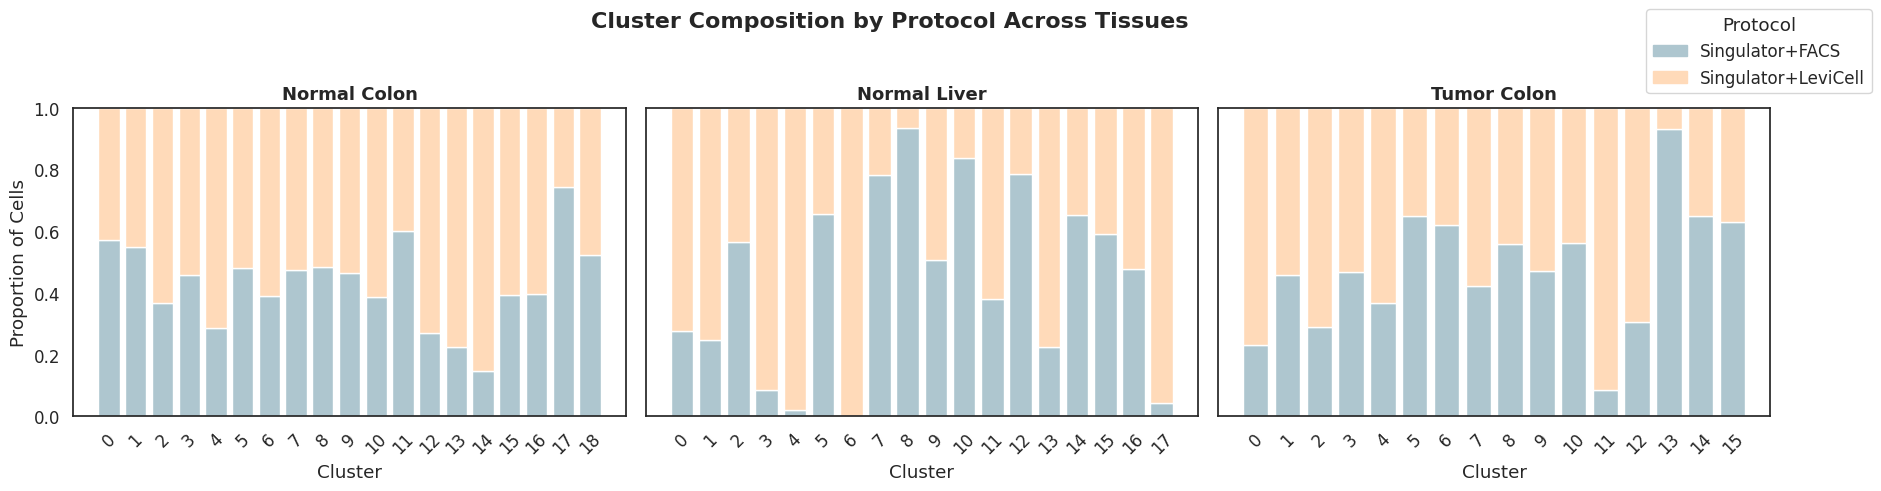

In [20]:
fig = plot_cluster_protocol_stackplots(
    combined_by_tissue=combined_by_tissue,
    cluster_key="leiden",
    protocol_key="protocol",
    protocol_palette=protocol_color_palette,
)
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "cluster_proportions_stackplot.png"))

#### Doublets by Protocol

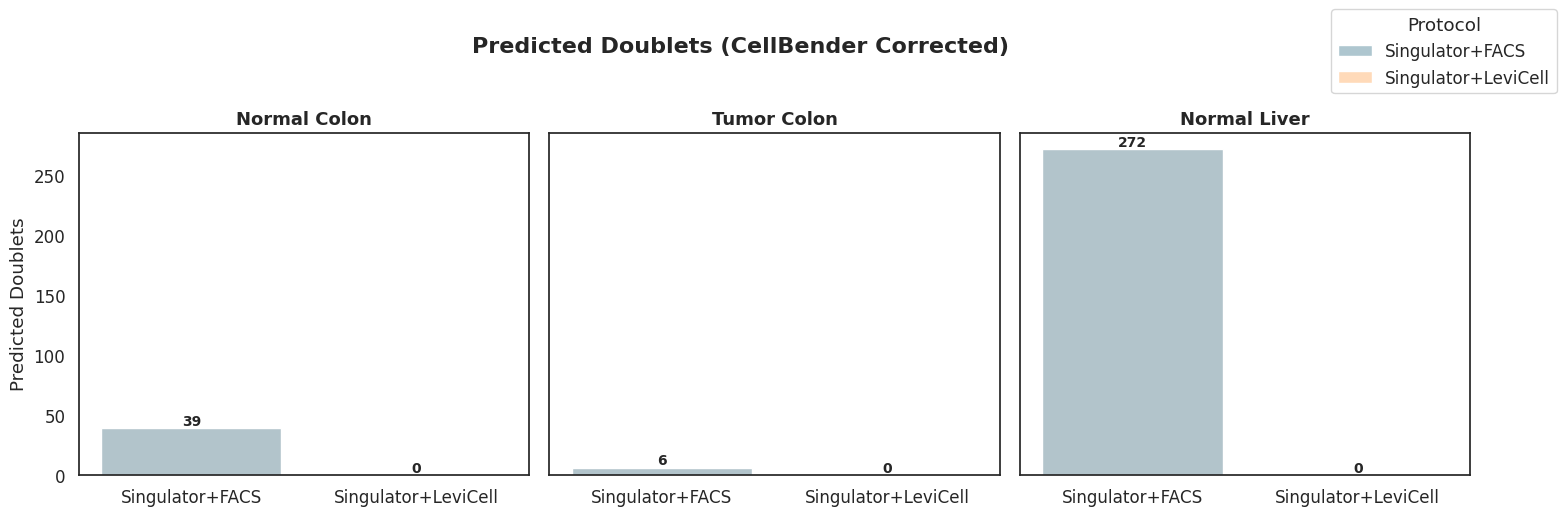

In [21]:
# Plot number of cells
fig = plot_adata_scalar_metric(
    adatas,
    adata_metadata=adata_metadata,
    metric_func=lambda adata: int(adata.obs["predicted_doublet"].sum()),
    metric_label="Predicted Doublets",
    protocol_color_palette=protocol_color_palette,
    title = "Predicted Doublets (CellBender Corrected)"
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "predicted_doublets_by_protocol.png"),
    bbox_inches="tight",
)

#### Doublet Score Histogram

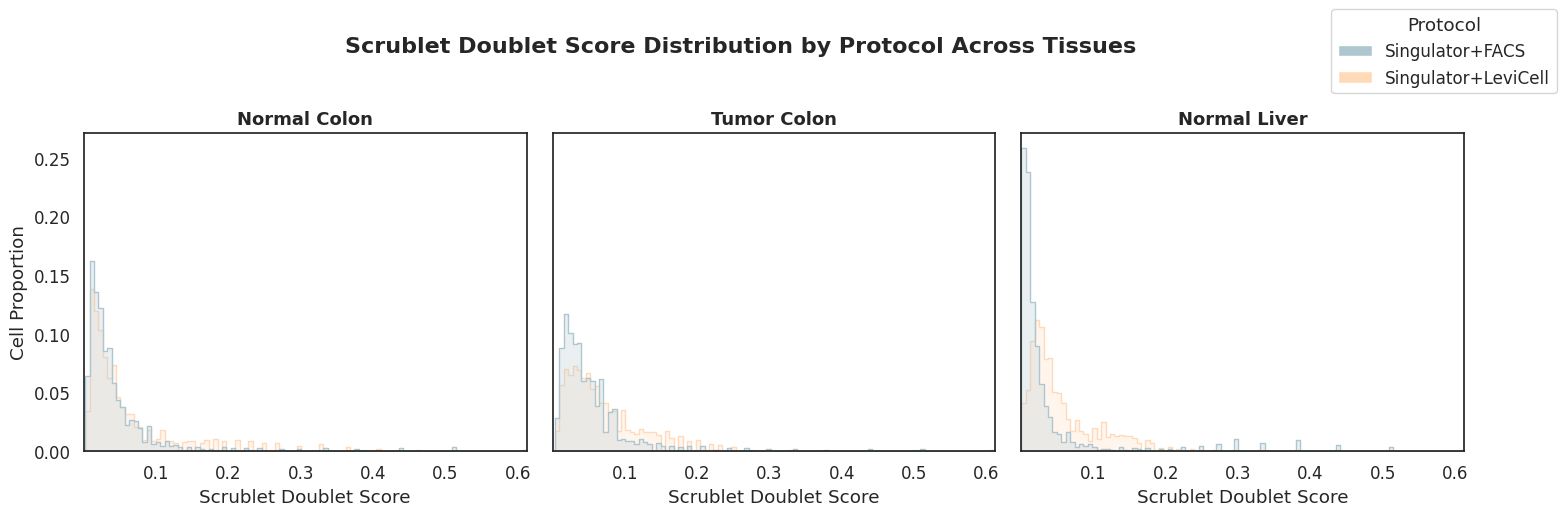

In [22]:
# Plot doublet score distribution
fig = plot_adata_metric_histogram(
    adatas,
    adata_metadata=adata_metadata,
    field="doublet_score",
    axis="obs",
    log_x=False,
    x_label="Scrublet Doublet Score",
    title="Scrublet Doublet Score Distribution by Protocol Across Tissues",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "scrublet_doublet_score_historgram.png"),
    bbox_inches="tight",
)

### Doublets by Cluster (Tumor Colon)

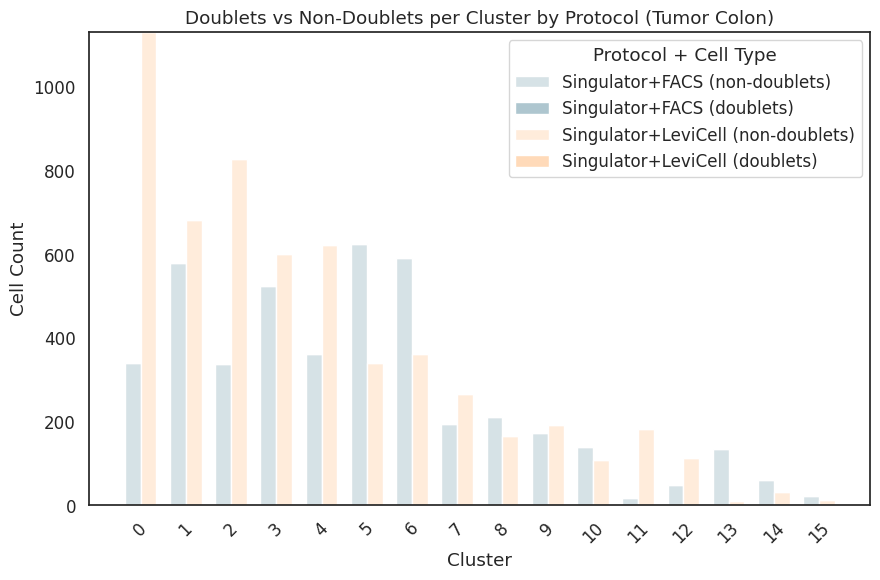

In [23]:
# Plot doublet score distribution by cluster
fig = plot_doublet_stack_by_cluster(
    combined_by_tissue, tissue="Tumor Colon", color_palette=protocol_color_palette
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "doublet_stack_by_cluster_tumor_colon.png"),
    bbox_inches="tight",
)

### Doublets by Cluster (Normal Liver)

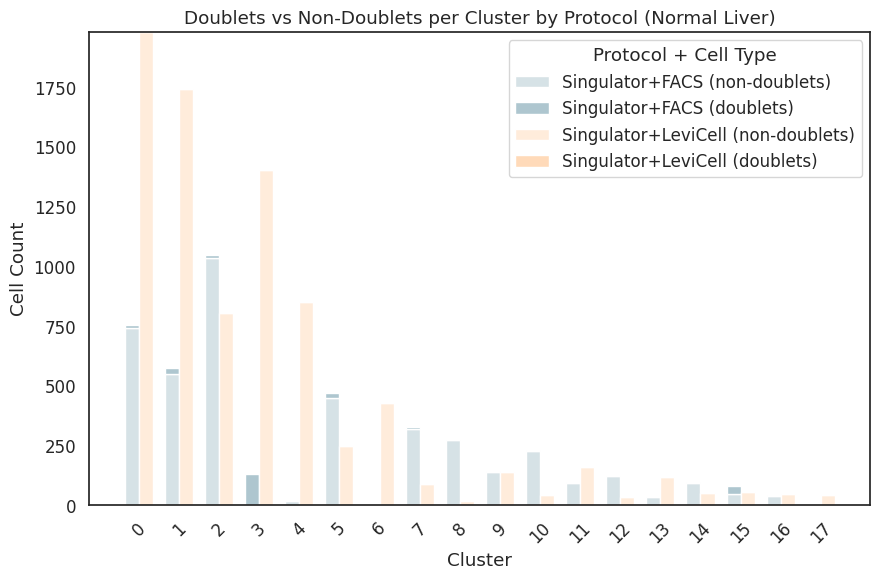

In [24]:
# Plot doublet score distribution by cluster
fig = plot_doublet_stack_by_cluster(
    combined_by_tissue, tissue="Normal Liver", color_palette=protocol_color_palette
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "doublet_stack_by_cluster_normal_liver.png"),
    bbox_inches="tight",
)

## Save AnnDatas

In [25]:
# Save AnnData to file:
for tissue, adata in combined_by_tissue.items():
    output_file = os.path.join(
        OUTPUT_ADATA_DIR, f"{tissue.replace(' ', '_')}_combined_adata.h5ad"
    )
    adata.write(output_file)
    print(f"Saved {tissue} combined AnnData to {output_file}")

for key, adata in adatas.items():
    output_file = os.path.join(OUTPUT_ADATA_DIR, f"{key}_adata.h5ad")
    adata.write(output_file)
    print(f"Saved {key} AnnData to {output_file}")

Saved Normal Colon combined AnnData to ./data/analysis/adatas/chapter_07_cellbender_UMAP_clustering/Normal_Colon_combined_adata.h5ad
Saved Tumor Colon combined AnnData to ./data/analysis/adatas/chapter_07_cellbender_UMAP_clustering/Tumor_Colon_combined_adata.h5ad
Saved Normal Liver combined AnnData to ./data/analysis/adatas/chapter_07_cellbender_UMAP_clustering/Normal_Liver_combined_adata.h5ad
Saved SF_N AnnData to ./data/analysis/adatas/chapter_07_cellbender_UMAP_clustering/SF_N_adata.h5ad
Saved SL_N AnnData to ./data/analysis/adatas/chapter_07_cellbender_UMAP_clustering/SL_N_adata.h5ad
Saved SF_T AnnData to ./data/analysis/adatas/chapter_07_cellbender_UMAP_clustering/SF_T_adata.h5ad
Saved SL_T AnnData to ./data/analysis/adatas/chapter_07_cellbender_UMAP_clustering/SL_T_adata.h5ad
Saved SF_LN AnnData to ./data/analysis/adatas/chapter_07_cellbender_UMAP_clustering/SF_LN_adata.h5ad
Saved SL_LN AnnData to ./data/analysis/adatas/chapter_07_cellbender_UMAP_clustering/SL_LN_adata.h5ad
